## 라이브러리 설치

In [1]:
from importlib.metadata import version
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
import cv2
import pixellib
import os
import urllib
import numpy as np
from PIL import Image
import glob

## Step 1. 인물모드 직접 해 보기
---
- 최소 3장 이상의 인물모드 사진을 만들어보자.
- semantic segmentation을 사용하여 인물이 아닌 다양한 object 아웃포커싱 사진을 만들어보자.
- 배경을 다른 사진으로 교채하여 배경합성해보기

### 1) 내사진으로 인물모드 적용해보기  
---
이번 모델인 PixelLib에서 사람을 제외하고도 새도 같이 인식을 할 수 있다고하니 새랑 같이 찍은 사진을 한번 써보기로 했다! 두근..!

(2880, 2160, 3)


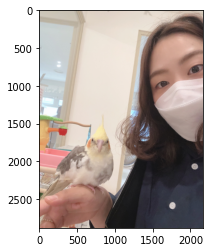

In [2]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/human_bird.jpg'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### PixelLib 모델 가져오기

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fa2f8a763a0>)

In [4]:
#PixelLib로 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path, output_image_name = "image_new.jpg", overlay = True)

Processed Image saved successfully in your current working directory.


In [6]:
#새로 생성된 이미지 저장
new_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image_new.jpg'
new_img = cv2.imread(new_img_path)

PixelLib으로 변환하기 전 사진입니다. 변환 전 Shape(2880, 2160, 3)


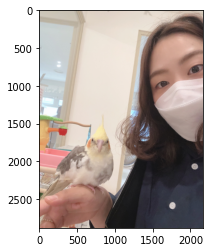

PixelLib으로 변환한 후 사진입니다. 변환 후 Shape(2880, 2160, 3)


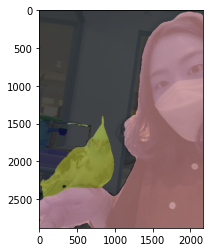

In [7]:
#PixelLib로 세그멘테이션 모델 전/후 사진 비교
print('PixelLib으로 변환하기 전 사진입니다. 변환 전 Shape{}'.format(img_orig.shape))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

print('PixelLib으로 변환한 후 사진입니다. 변환 후 Shape{}'.format(new_img.shape))
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
plt.show()

변환한 후 shape은 변하지 않고 색상만 바뀐 것을 알 수 있습니다.  

오 신기하게 새는 따로 인식한 것이 보입니다. 역시 신기한 세계....o0o  

하지만 머리카락부분을 보면, 머리카락 사이에 배경은 배경이 아니라 사람으로 묶어서 인식해버리네요! 이건 나중에 blur처리를 하면 배경이지만 blur처리가 안될 것 같습니다. 과연 어떻게 될지 궁금하네요! 

In [12]:
#PASCAL VOC의 데이터 라벨 종류입니다.
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [10]:
#분할 출력의 배열을 가져옵시다.
segvalues, output = model.segmentAsPascalvoc(img_path)

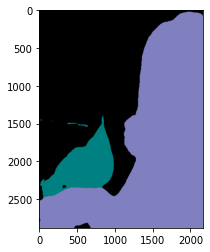

In [11]:
#출력된 모델을 살펴봅시다
plt.imshow(output)
plt.show()

오 배경을 검게하고 보니 새뒤의 막대도 새로 잘못 인식한 것을 알 수 있습니다.  
오이오이.. 그건 새가 아니라규

pixellib에서 인식하는 객체 및 해당 컬러맵입니다. 
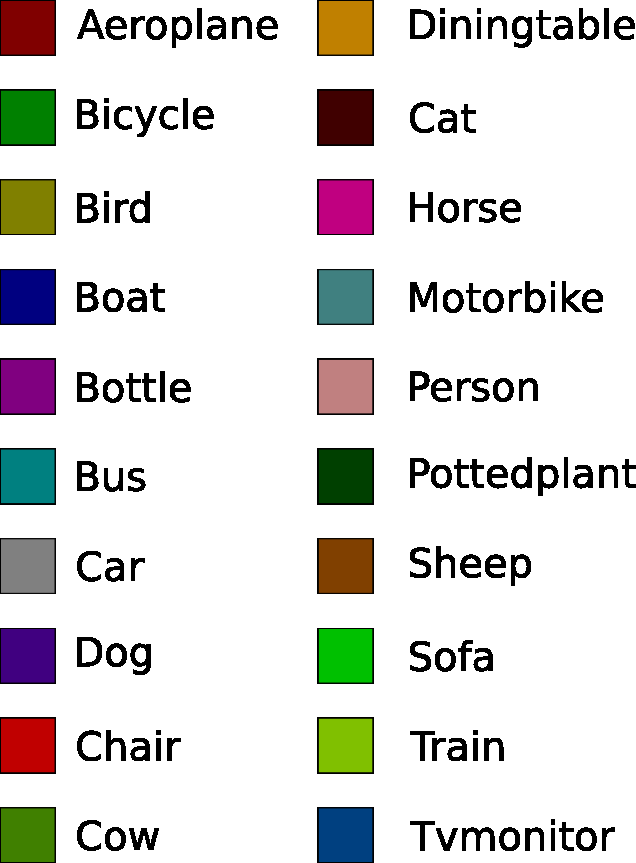

출처 : [pixellib 공식홈페이지](https://pixellib.readthedocs.io/en/latest/Image_pascal.html)

In [12]:
#segment의 value값들과 인식한 라벨을 봅시다.
segvalues

{'class_ids': array([ 0,  3, 15, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [13]:
#라벨값을 확인해봅시다
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bird
person
pottedplant


오.... 배경, 새, 사람에 이어서 화분이 나옵니다!    

몰랐는데, 뒤에 막대를 새로 인식한게 아니라 화분으로 인식한거였습니다.오.... 하지만 틀렸다 요놈!

In [14]:
# PixelLib에서 그대로 가져온 코드입니다
# 물체별로 색상을 알아내면 될 것 같습니다
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:21]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0],
       [  0,  64, 128]])

위에서 말했던 LABEL_NAMES 별로 가지고 있는 색상들입니다.  
여기서 `colormap`은 RBG 순서이고 `output` 이미지는 BGR 순서로 되있는 점을 유의하여 색상을 바꿔줍니다.  
그럼 새인 3, 사람인 15번째 색상을 불러 BRG로 교체합니다.

In [15]:
print('새의 RGB 색상은 {}입니다. 사람의 RGB색상은 {}입니다.'.format(colormap[3], colormap[15]))

새의 RGB 색상은 [128 128   0]입니다. 사람의 RGB색상은 [192 128 128]입니다.


In [16]:
seg_color_person = (128,128,192) 
seg_color_bird = (0,128,128)

`seg_map = np.all(output == seg_color, axis = -1)`의 기존 식에서 output과 비교해야하는 seg_color가 2종류다보니 오류가 납니다.  

어떻게 해결할까 고민하다, 두개를 따로 boolen 형태로 만들어주고, 합치는 방향으로 진행해보려합니다. 

In [17]:
#사람의 seg_map
seg_map_person = np.all(output == seg_color_person, axis = -1)

#새의 seg_map
seg_map_bird = np.all(output == seg_color_bird, axis = -1)

In [18]:
#두종류의 seg_map 합치기
seg_map_all = np.where((seg_map_person | seg_map_bird), True, False)

In [19]:
seg_map_all

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

(2880, 2160)


<function matplotlib.pyplot.show(close=None, block=None)>

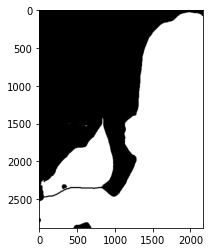

In [20]:
#이제 seg_color_all로만 이뤄진 마스크를 만들어보자
print(seg_map_all.shape)
plt.imshow(seg_map_all, cmap = 'gray')
plt.show

캬..... 여기에 나오지 않은 많은 과정이 있었지만...^_ㅠ... 이렇게 이쁘게 합쳐지니 기분이 좋네욯ㅎㅎㅎㅎ  

이제, 3채널 가졌던 원본과는 다르게 채널 정보가 사라지고 1, 0의 배열이 되었습니다. 이제 원본 이미지와 비교해서 얼마나 잘됬는지 확인해보겠습니다.

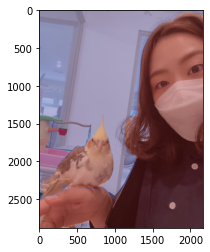

In [21]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map_all.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

#원본 이미지와 마스크를 적당한 비율로 합쳐봅니다.
img_show = cv2.addWeighted(img_show, 0.7, color_mask, 0.3, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

새와 사람만 구분하여 넣어서 문제가 되었던 뒤쪽 나무는 삭제되었습니다:)!

#### 배경 흐리게 하기
---
blurring kernel size를 기존 (13,13), (50,50)으로 나눠서 한번 진행해보겠습니다.

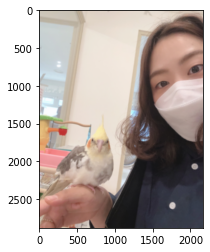

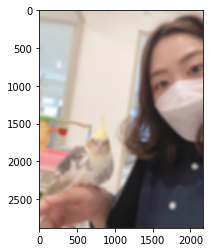

In [22]:
img_orig_blur_13 = cv2.blur(img_orig, (13,13))
img_orig_blur_50 = cv2.blur(img_orig, (50,50))

plt.imshow(cv2.cvtColor(img_orig_blur_13, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_orig_blur_50, cv2.COLOR_BGR2RGB))
plt.show()

blurring kernel size는 흐림의 정도를 나타내는 것이었습니다.  
저는 확실한 효과를 위해 (50,50)으로 해보겠습니다!

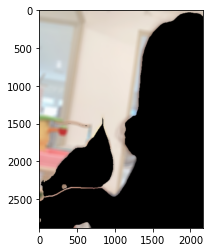

In [23]:
#배경 추출하기
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur_50, img_bg_mask)

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

`bitwise_not` 함수를 이용하면 이미지가 반전되었습니다. 원래 마스크에서는 배경이 `0`, 사람이 `255`였으니 `bitwise_not` 연산을 해서, 배경은 `255`, 사람은 `0`이 되었습니다.

반전된 세그멘테이션 결과를 이용해서 이미지와 `bitwise_and` 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다. 0과 어떤 수를 `bitwise_and` 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지게 되는 거죠.


#### 흐린 배경과 원본 사진 합성

---

이제 배경과 사람을 `concat`으로 합쳐줍니다!

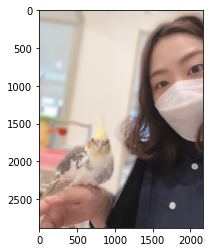

In [24]:
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

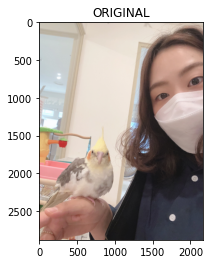

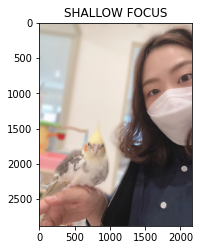

In [25]:
######원본과 비교해보기

plt.subplot(1, 1, 1)  
plt.title('ORIGINAL')
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

plt.subplot(1, 2, 2)  
plt.title('SHALLOW FOCUS')
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

야호~~~~~~ 완성되었습니다:)! 

### 2) 강아지사진으로 인물모드 적용해보기  
---
세상에서 제일 귀여운 우리 나무씨 백구씨를 인물모드해보겠읍니다!

(3024, 4032, 3)


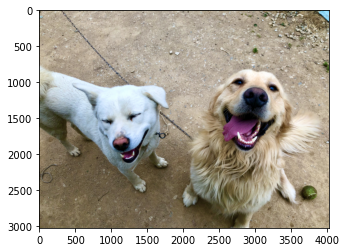

In [26]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cute_dog.jpg'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

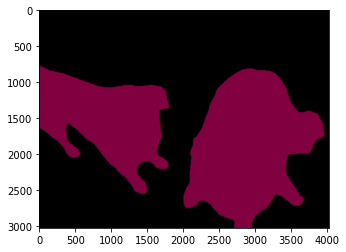

In [27]:
segvalues, output = model.segmentAsPascalvoc(img_path)

plt.imshow(output)
plt.show()

In [28]:
segvalues

{'class_ids': array([ 0, 12]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [29]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


In [30]:
####개의 컬러맵을 따줍니다
colormap[12]

array([ 64,   0, 128])

(3024, 4032)


<function matplotlib.pyplot.show(close=None, block=None)>

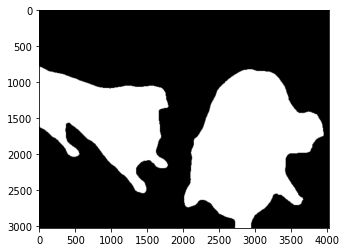

In [31]:
seg_color = (128, 0, 64)

seg_map = np.all(output == seg_color, axis = -1)
print(seg_map.shape)
plt.imshow(seg_map, cmap = 'gray')
plt.show

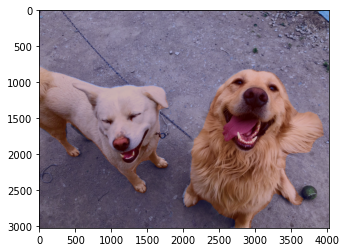

In [32]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

#원본 이미지와 마스크를 적당히 합쳐봅니다.
#0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.7, color_mask, 0.3, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

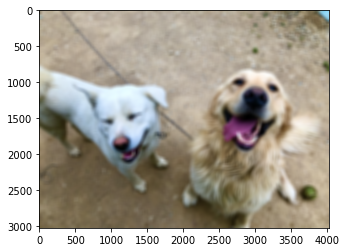

In [33]:
####배경 흐리게 하기
####초카와이한 나무와 백구를 더 돋보이게하기위해 블러를 빡시게 줍니다.

img_orig_blur = cv2.blur(img_orig, (60,60))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

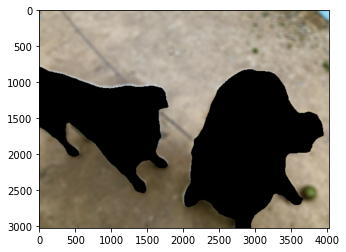

In [34]:
####흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

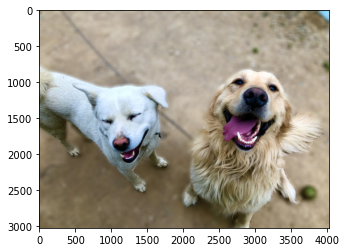

In [35]:
#####콘캣!!!!!!!!!!!!!!!!!!!!!!!!!!!
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

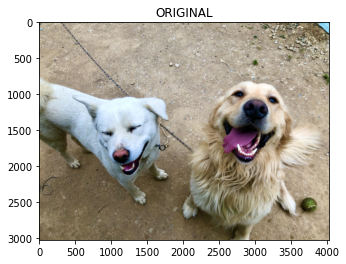

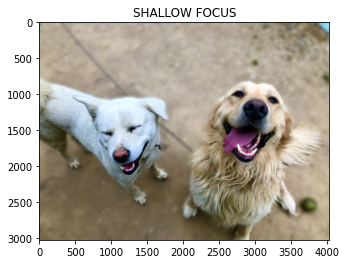

In [36]:
######원본과 비교해보기

plt.title('ORIGINAL')
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

plt.title('SHALLOW FOCUS')
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

멍뭉이들 다리까지 잘 따진것을 볼 수 있습니다!  
기....기여워.....핰핰.....   

근데 잘보면 백구의 살짝 나온 뒷다리 한쪽은 블러처리가 된 것을 보아, 세그멘테이션을 정교하게 따지는 못한다고 할 수 있겠네요.

### 3) 배경 전환 크로마키 사진
---
차보스트레인지만들기 도전!

(4032, 3024, 3)


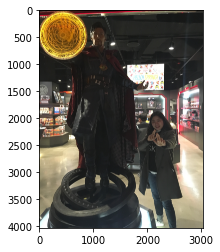

In [8]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/chabo.jpg'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

사진을 가져왔으니 동일하게 마스크를 따줍니다.

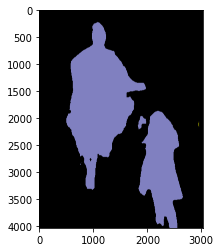

In [9]:
segvalues, output = model.segmentAsPascalvoc(img_path)

plt.imshow(output)
plt.show()

In [13]:
segvalues

for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bus
person


버스는 모죠...!? 사람만 따서 넣어줍니다

(4032, 3024)


<function matplotlib.pyplot.show(close=None, block=None)>

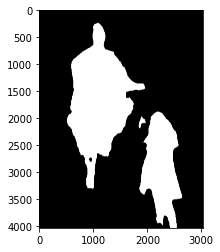

In [14]:
seg_color = (128,128,192)

seg_map = np.all(output == seg_color, axis = -1)
print(seg_map.shape)
plt.imshow(seg_map, cmap = 'gray')
plt.show

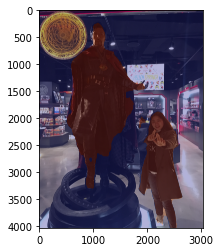

In [15]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

#원본 이미지와 마스크를 적당히 합쳐봅니다.
#0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.7, color_mask, 0.3, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


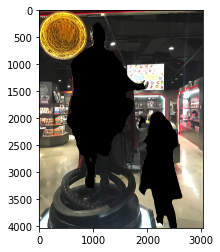

In [34]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig, img_bg_mask)

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

자 이제 닥터스트레인지와 차보스트레인지 둘다 생텀으로 보내줍시닼ㅋㅋㅋㅋ

In [30]:
###그럼 이제 배경을 생텀으로 바꿔줍시다.
background_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.jpg'
back_img = cv2.imread(background_path)

##배경 사이즈 맞춰주기
back_img_resize = cv2.resize(back_img, (3024, 4032))

In [31]:
print(back_img_resize.shape)
print(seg_map.shape)
print(img_orig.shape)

(4032, 3024, 3)
(4032, 3024)
(4032, 3024, 3)


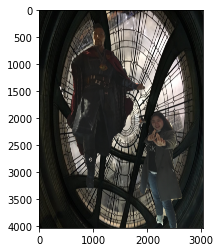

In [35]:
img_concat = np.where(img_mask_color == 255, img_orig, back_img_resize)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

ㅇㅖ~ 사이좋게 런던생텀에서 만났습니다!!!!!!ㅋㅋㅋㅋㅋㅋㅋㅋㅋ   
이게뭐라고 재밌는지....ㅋㅋㅋㅋㅋㅋ

## Step 2. 사진에서 문제점 찾기
---
만들어진 사진에서 어색한 부분들을 찾아서 표시해보자.

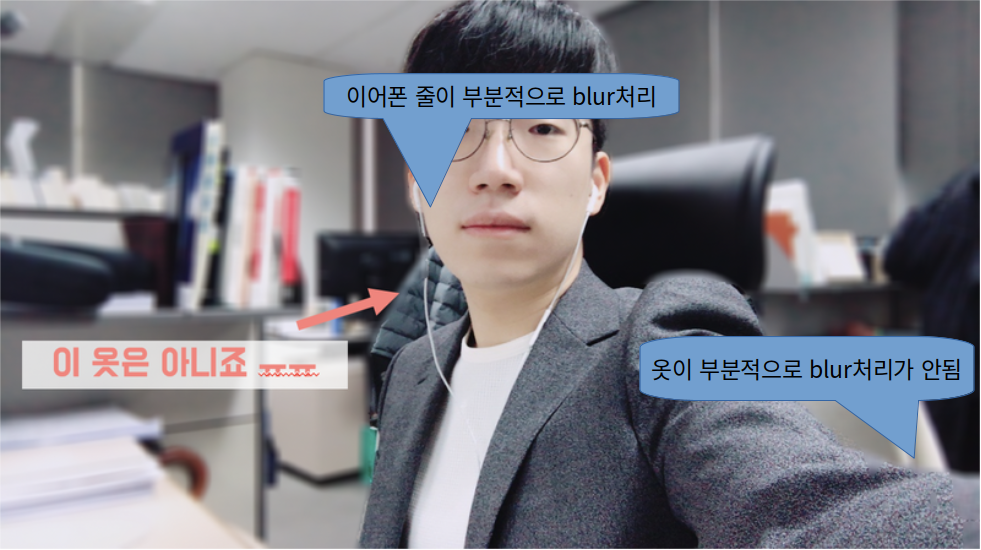

### 제작한 인물모드 사진에서 어색한 부분 표시

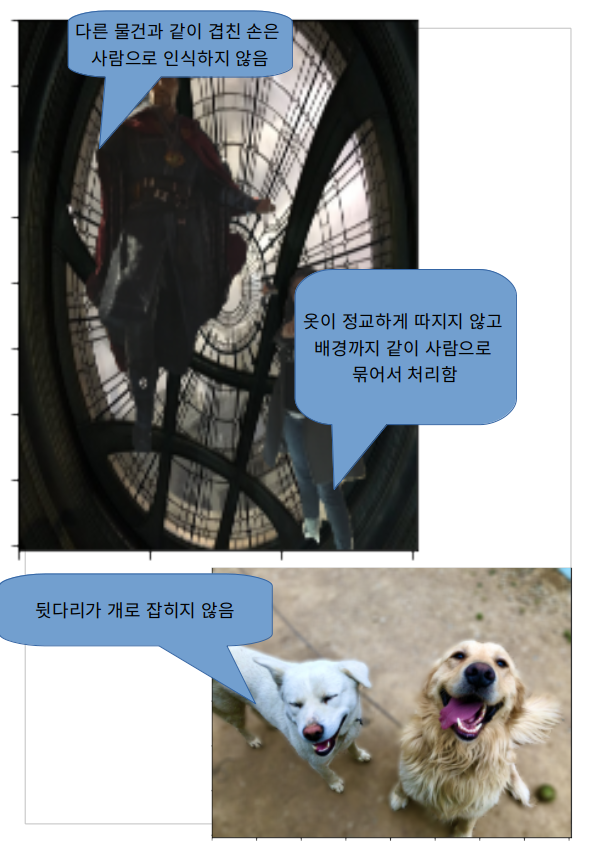

## Step 3. 솔루션 제안
---

- 현재 사용한 Segmantic Segmantation이 물체를 정교하게 캐치하지 못해서 blur처리가 안되거나 포괄적으로 묶여서 blur처리가 덜되는 등의 문제가 발생하였다. 

- 
피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation)
이를 모방한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기 어려움
